# 데이터 불러오기

In [15]:
import pandas as pd

# CSV 파일 읽기
df_sensor = pd.read_csv('../src/merged_data.csv')

# (1) 이진 변수 판별: "해당 컬럼의 유일한 값이 {0, 1}만 존재"하는 경우
binary_cols = [
    col for col in df_sensor.columns 
    if set(df_sensor[col].dropna().unique()) == {0, 1}
]

# (2) 이진 변수를 제외한 새로운 데이터프레임
df_sensor_nonbinary = df_sensor.drop(columns=binary_cols)

# 결과 확인
df_sensor_nonbinary.head()


,KFIGIV,KJMVXE,KSENS,KZRODN,NBANK,NCRODB,NCRSTEP,NZOVLAP,NZON,KXEDYN,...,KSWO274,KSWO275,KSWO276,KSWO277,KSWO278,KSWO279,KSWO280,KSWO319,KSWO320,label
0,1,1,300,228,8,8,228,114,25,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,300,228,8,8,228,114,25,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,300,228,8,8,228,114,25,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,300,228,8,8,228,114,25,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,300,228,8,8,228,114,25,1,...,0,0,0,0,0,0,0,0,0,0


70%는 훈련 데이터로, 30%는 테스트 세트로 나눈다.

In [16]:
from sklearn.model_selection import train_test_split

X, y = df_sensor_nonbinary.iloc[:, :-1].values, df_sensor_nonbinary.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

In [17]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

공분산 행렬의 고윳값 분해

In [18]:
import numpy as np
cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eigh(cov_mat)

print('\n고윳값 \n', eigen_vals)


고윳값 
 [-1.71960317e-11 -1.14973149e-11 -9.50426777e-12 ...  3.53017859e+01
  7.47312182e+01  3.88047629e+02]


## 총 분산과 설명된 분산

In [19]:
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

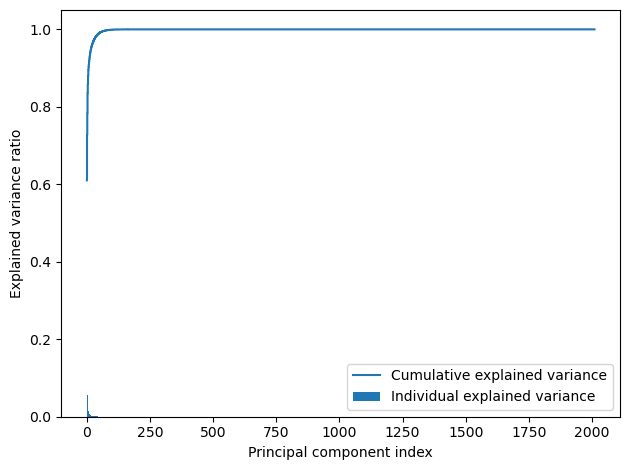

In [21]:
import matplotlib.pyplot as plt


plt.bar(range(1, 2010), var_exp, align='center',
        label='Individual explained variance')
plt.step(range(1, 2010), cum_var_exp, where='mid',
         label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
# plt.savefig('figures/05_02.png', dpi=300)
plt.show()

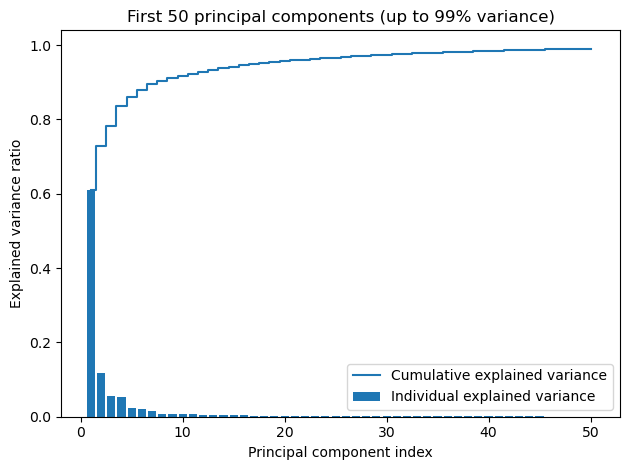

In [23]:
# 누적 분산이 95%가 넘는 지점까지만 시각화하기
threshold = 0.99
# 누적 분산이 threshold 이상이 되는 첫 번째 지점의 인덱스를 구함
idx_cut = np.argmax(cum_var_exp >= threshold) + 1  # 1-based index

# 막대 그래프(개별 주성분 분산) & 계단 그래프(누적 분산)를 그리되, idx_cut까지만 표시
plt.bar(range(1, idx_cut+1), var_exp[:idx_cut], align='center',
        label='Individual explained variance')
plt.step(range(1, idx_cut+1), cum_var_exp[:idx_cut], where='mid',
         label='Cumulative explained variance')

plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.title(f'First {idx_cut} principal components (up to {threshold*100:.0f}% variance)')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

## 특성 변환

In [24]:
# (고윳값, 고유벡터) 튜플의 리스트를 만듭니다
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
               for i in range(len(eigen_vals))]

# 높은 값에서 낮은 값으로 (고윳값, 고유벡터) 튜플을 정렬합니다
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

In [25]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis],
               eigen_pairs[1][1][:, np.newaxis]))
print('투영 행렬 W:\n', w)

투영 행렬 W:
 [[0. 0.]
 [0. 0.]
 [0. 0.]
 ...
 [0. 0.]
 [0. 0.]
 [0. 0.]]


In [26]:
X_train_std[0].dot(w)

array([12.53283206, -9.87052317])

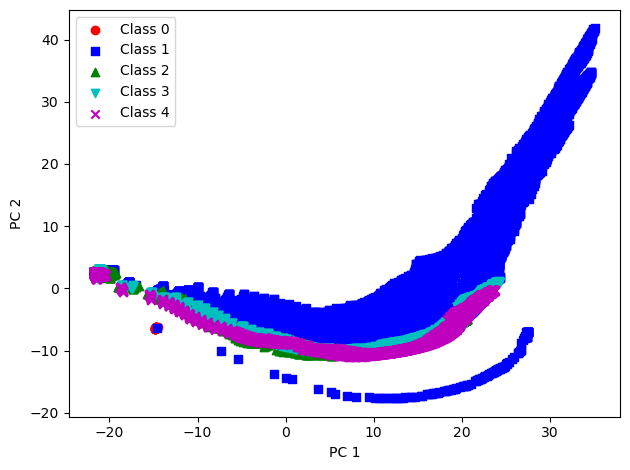

In [28]:
import matplotlib.pyplot as plt
import numpy as np

X_train_pca = X_train_std.dot(w)

# 5개의 색상과 마커를 준비
colors = ['r', 'b', 'g', 'c', 'm']  # 예: 빨강, 파랑, 초록, 청록, 자홍
markers = ['o', 's', '^', 'v', 'x'] # 예: 원, 사각, 삼각, 아래삼각, x표

# np.unique(y_train)이 5개 클래스라면,
# zip으로 묶어서 순회
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(
        X_train_pca[y_train == l, 0],
        X_train_pca[y_train == l, 1],
        c=c,
        label=f'Class {l}',
        marker=m
    )

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


# 사이킷런의 주성분 분석

In [29]:
from sklearn.decomposition import PCA

pca = PCA()
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([6.10133529e-01, 1.17501096e-01, 5.55055658e-02, ...,
       9.33507284e-34, 3.48277991e-34, 3.45799766e-35])

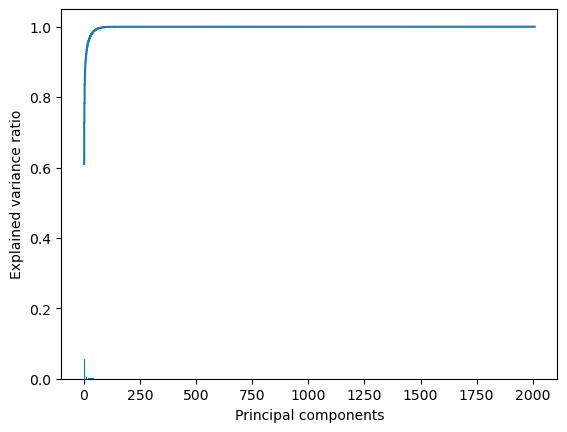

In [30]:
plt.bar(range(1, 2010), pca.explained_variance_ratio_, align='center')
plt.step(range(1, 2010), np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')

plt.show()

In [35]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

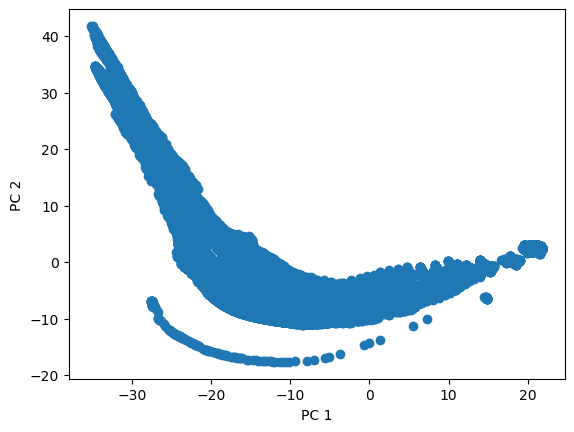

In [36]:
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1])
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

In [37]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # 마커와 컬러맵을 준비합니다
# 5개의 색상과 마커를 준비
    colors = ['r', 'b', 'g', 'c', 'm']  # 예: 빨강, 파랑, 초록, 청록, 자홍
    markers = ['o', 's', '^', 'v', 'x'] # 예: 원, 사각, 삼각, 아래삼각, x표
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # 결정 경계를 그립니다
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # 클래스별로 샘플을 그립니다
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=f'Class {cl}',
                    edgecolor='black')

In [38]:
from sklearn.linear_model import LogisticRegression

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

lr = LogisticRegression(multi_class='ovr', random_state=1, solver='lbfgs')
lr = lr.fit(X_train_pca, y_train)

c:\Users\iinmv\anaconda3\envs\nuclear_bootcamp\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


C:\Users\iinmv\AppData\Local\Temp\ipykernel_19376\3950803128.py:24: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],


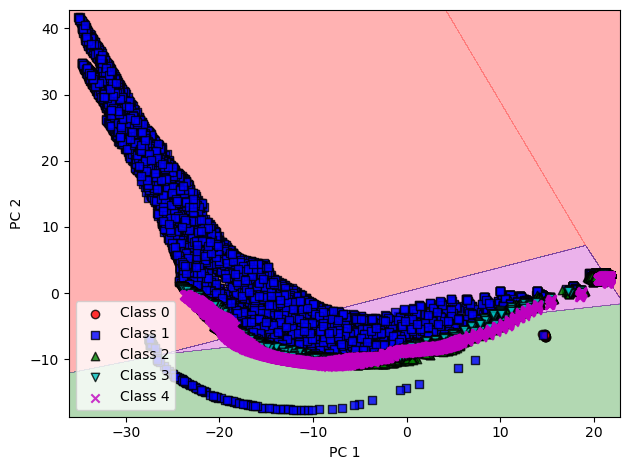

In [39]:
plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('figures/05_04.png', dpi=300)
plt.show()

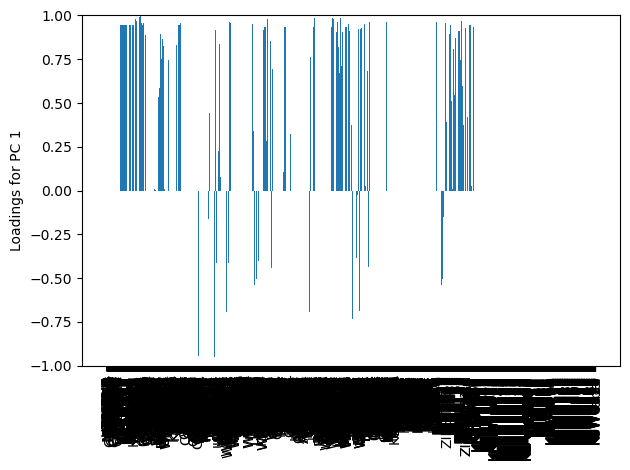

In [41]:
eigen_vals = pca.explained_variance_
eigen_vecs = pca.components_.T

loadings = eigen_vecs * np.sqrt(eigen_vals)

fig, ax = plt.subplots()

ax.bar(range(2009), loadings[:, 0], align='center')
ax.set_ylabel('Loadings for PC 1')
ax.set_xticks(range(2009))
ax.set_xticklabels(df_sensor_nonbinary.columns[1:], rotation=90)

plt.ylim([-1, 1])
plt.tight_layout()
# plt.savefig('figures/05_05_02.png', dpi=300)
plt.show()

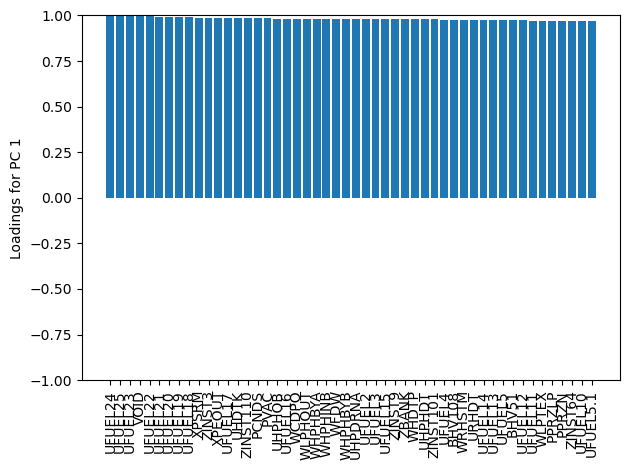

In [43]:
# 1. PCA 결과에서 고윳값(eigen_vals)와 고유벡터(eigen_vecs) 불러오기
eigen_vals = pca.explained_variance_
eigen_vecs = pca.components_.T

# 2. PC1에 대한 로딩값 계산
loadings = eigen_vecs * np.sqrt(eigen_vals)
loadings_pc1 = loadings[:, 0]  # 첫 번째 주성분(PC1)만 사용

# 3. 변수 이름 추출 (예: df_sensor_nonbinary의 첫 열이 ID 등이면 [1:]로 특성만)
var_names = df_sensor_nonbinary.columns[1:]

# 4. 절댓값 기준으로 중요도가 큰 순서대로 정렬
idx_sorted = np.argsort(np.abs(loadings_pc1))[::-1]  # 내림차순 정렬

# 5. 상위 N개만 선택 (예: 20개)
top_n = 50
idx_top_n = idx_sorted[:top_n]

# 6. 상위 N개 로딩과 변수명만 추출
top_loadings = loadings_pc1[idx_top_n]
top_var_names = var_names[idx_top_n]

# 7. 시각화 (상위 N개만 보기)
fig, ax = plt.subplots()

ax.bar(range(top_n), top_loadings, align='center')
ax.set_xticks(range(top_n))
ax.set_xticklabels(top_var_names, rotation=90)
ax.set_ylabel('Loadings for PC 1')

# 로딩값 범위에 맞춰 y축 제한 (필요 시 조정)
plt.ylim([-1, 1])
plt.tight_layout()
plt.show()